In [1]:
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torch.utils.data import DataLoader

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_new_complex.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


In [8]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


In [9]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 1, 4, 128, 128])
Restored targets Shape: torch.Size([10, 48, 2, 128, 128])


Text(0.5, 1.0, 'Water Depth time step 0')

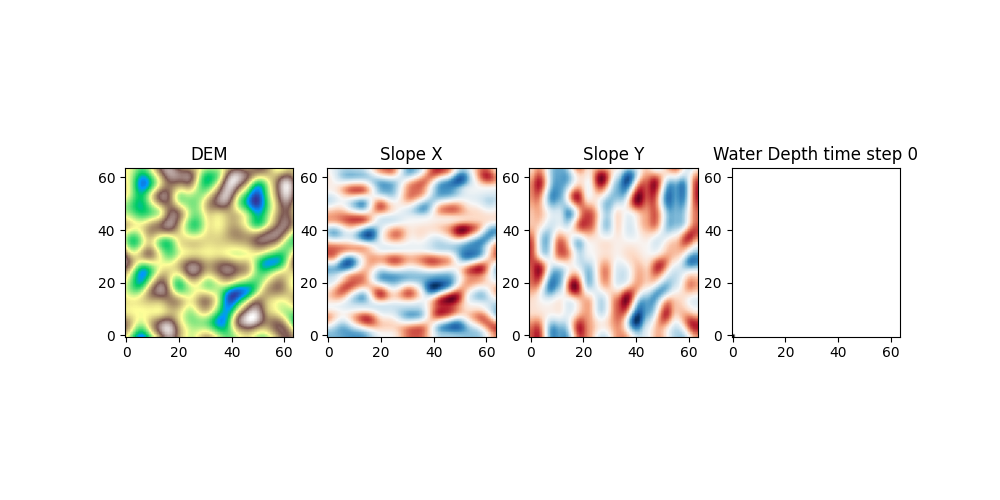

In [10]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[numb][0][0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(train_dataset[numb][0][0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[numb][0][0][3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Water Depth time step 0')

In [11]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q)
norm_test1 = normalize_dataset(test_dataset1, scaler_x, scaler_wd, scaler_q)
norm_test2 = normalize_dataset(test_dataset2, scaler_x, scaler_wd, scaler_q)
norm_test3 = normalize_dataset(test_dataset3, scaler_x, scaler_wd, scaler_q)

In [13]:
# Model: has to be the same as in other notebook
model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1],
                 hidden_dim = 8, kernel_size = (5, 5), num_layers = normalized_train_dataset[0][1].shape[0], batch_first=True,bias=True, return_all_layers = True).to(device)

In [14]:
model

ConvLSTM(
  (conv2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (4): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (5): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (6): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (7): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (8): ConvLSTMCel

In [15]:
# Create the test dataloaders to "feed" data to the model
test1_loader = DataLoader(norm_test1, batch_size = 8, shuffle = False)
test2_loader = DataLoader(norm_test2, batch_size = 8, shuffle = False)
test3_loader = DataLoader(norm_test3, batch_size = 8, shuffle = False)

In [16]:
# load model no avoid training every time notebook is run
model.load_state_dict(torch.load(save_path, map_location = torch.device(device)))

<All keys matched successfully>

In [17]:
test_loss = evaluation_conv_lstm(model, test1_loader, device=device)

In [18]:
test_loss2 = evaluation_conv_lstm(model, test2_loader, device=device)

In [19]:
test_loss3 = evaluation_conv_lstm(model, test3_loader, device=device)

In [20]:
print(f'Test_loss:\n'
      f'\t First test dataset: {test_loss :.4f}\n'
      f'\t Second test dataset: {test_loss2 :.4f}\n'
      f'\t Third test dataset: {test_loss3 :.4f}')

Test_loss:
	 First test dataset: 0.0014
	 Second test dataset: 0.0032
	 Third test dataset: 0.0023


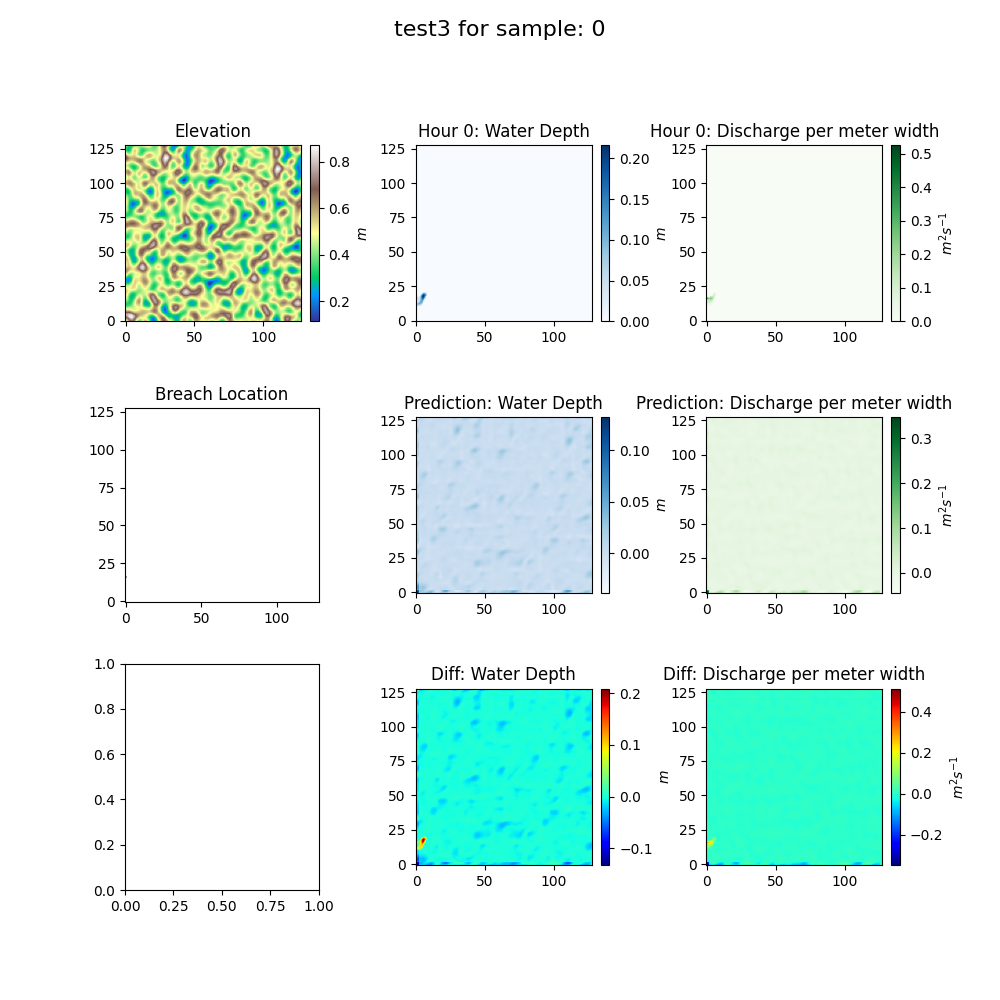

MovieWriter Pillow unavailable; using Pillow instead.


In [27]:
plot_animation(0, norm_test3, model, test3, 'conv_lstm', device = device, save = True)

Attempt at denormalizing data in animation function

In [21]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib import animation
# import torch

# def plot_animation(sample, dataset, model, title_anim, model_who, scaler_x, scaler_y, device = 'cuda', save = False):
#     '''

#     Parameters
#     ----------
#     sample : int
#         Choose a sample to animate.
#     dataset : torch.utils.data.Dataset
#         dataset of train_val or test, in future, two datasets should be parameters.
#     model : class of model
#         model to predict on the sample
#     title_anim : str
#         title of the animation.
#     model_who : str
#         identifies which model is used to get a prediction
#         currently only contains "conv_lstm" a
#     save : bool
#         The default is False, if true will save the animation in the
#         post_processing folder with the title in the format 'title_anim + sample'

#     Returns
#     -------
#     None.

#     '''
#     # bottom right graph could be the losses at each hour for both outputs
#     inputs_denorm = scaler_x.inverse_transform(dataset[sample][0].unsqueeze(0)[0][0].reshape(4, -1).T)
#     targets_denorm = scaler_y.inverse_transform(dataset[sample][1].unsqueeze(0)[0].reshape(48, 2, 64, 64))
    
#     if model_who == 'conv_lstm':
#         sample_list, _ = model(dataset[sample][0].unsqueeze(0).to(device)) # create a batch of 1?
#         preds = torch.cat(sample_list, dim=1).detach().cpu()[0] # remove batch
    
#     feature1 = 0
#     feature2 = 1
    
#     feature_dic = {
#         0: 'Water Depth',
#         1: 'Discharge per meter width'
#     }

#     feature_dic_units = {
#         0: r'$m$',
#         1: r'$m^2 s^{-1}$'
#     }

#     fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10))
#     fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

#     # Subplot 1
#     div1 = make_axes_locatable(ax1)
#     cax1 = div1.append_axes('right', '5%', '5%')

#     static_tensor = inputs_denorm[:, 0].reshape(64, 64)   # index 0 refers to elevation
#     im1 = ax1.imshow(static_tensor, cmap = 'terrain', origin='lower')
#     cb1 = fig.colorbar(im1, cax=cax1)
#     cb1.set_label(r'$m$')
#     ax1.set_title('Elevation')

#     # Subplot 4
#     static_tensor2 = inputs_denorm[:, -1].reshape(64, 64)  # index 3 refers to boundary
#     ax4.imshow(static_tensor2, cmap = 'binary', origin='lower')
#     ax4.set_title('Breach Location')

#     # Subplot 2
#     div2 = make_axes_locatable(ax2)
#     cax2 = div2.append_axes('right', '5%', '5%')

#     animated_tensor1 = targets_denorm[:, :, feature1].reshape(64, 64)
#     im2 = ax2.imshow(animated_tensor1[0], cmap = 'Blues', origin='lower')
#     cb2 = fig.colorbar(im2, cax=cax2)
#     cb2.set_label(f'{feature_dic_units[feature1]}')
#     tx2 = ax2.set_title(f'Hour 0: {feature_dic[feature1]}')

#     # Subplot 3
#     div3 = make_axes_locatable(ax3)
#     cax3 = div3.append_axes('right', '5%', '5%')

#     animated_tensor2 = targets_denorm[:, :, feature2].reshape(64, 64)
#     im3 = ax3.imshow(animated_tensor2[0], cmap = 'Greens', origin='lower')
#     cb3 = fig.colorbar(im3, cax=cax3)
#     cb3.set_label(f'{feature_dic_units[feature2]}')
#     tx3 = ax3.set_title(f'Hour 0: {feature_dic[feature2]}')

#     # Subplot 5
#     div5 = make_axes_locatable(ax5)
#     cax5 = div5.append_axes('right', '5%', '5%')

#     animated_tensor3 = preds[:, feature1]
#     im5 = ax5.imshow(animated_tensor3[0], cmap = 'Blues', origin='lower')
#     cb5 = fig.colorbar(im5, cax=cax5)
#     cb5.set_label(f'{feature_dic_units[feature1]}')
#     tx5 = ax5.set_title(f'Prediction: {feature_dic[feature1]}')

#     # Subplot 6
#     div6 = make_axes_locatable(ax6)
#     cax6 = div6.append_axes('right', '5%', '5%')

#     animated_tensor4 = preds[:, feature2]
#     im6 = ax6.imshow(animated_tensor4[0], cmap = 'Greens', origin='lower')
#     cb6 = fig.colorbar(im6, cax=cax6)
#     cb6.set_label(f'{feature_dic_units[feature2]}')
#     tx6 = ax6.set_title(f'Prediction: {feature_dic[feature2]}')

#     # Subplot 8
#     div8 = make_axes_locatable(ax8)
#     cax8 = div8.append_axes('right', '5%', '5%')

#     animated_tensor5 = animated_tensor1 - animated_tensor3
#     im8 = ax8.imshow(animated_tensor5[0], cmap = 'jet', origin='lower')
#     cb8 = fig.colorbar(im8, cax=cax8)
#     cb8.set_label(f'{feature_dic_units[feature1]}')
#     tx8 = ax8.set_title(f'Diff: {feature_dic[feature1]}')

#     # Subplot 9
#     div9 = make_axes_locatable(ax9)
#     cax9 = div9.append_axes('right', '5%', '5%')

#     animated_tensor6 = animated_tensor2 - animated_tensor4
#     im9 = ax9.imshow(animated_tensor6[0], cmap = 'jet', origin='lower')
#     cb9 = fig.colorbar(im9, cax=cax9)
#     cb9.set_label(f'{feature_dic_units[feature2]}')
#     tx9 = ax9.set_title(f'Diff: {feature_dic[feature2]}')

#     fig.suptitle(title_anim + f' for sample: {sample}', fontsize=16)

#     def animate(i):
#         # Subplot 2
#         arr1 = animated_tensor1[i]
#         max_val1 = arr1.max()
#         min_val1 = arr1.min()
#         im2.set_data(arr1)
#         im2.set_clim(min_val1, max_val1)
#         tx2.set_text(f'Hour {i}: {feature_dic[feature1]}')

#         # Subplot 3
#         arr2 = animated_tensor2[i]
#         max_val2 = arr2.max()
#         min_val2 = arr2.min()
#         im3.set_data(arr2)
#         im3.set_clim(min_val2, max_val2)
#         tx3.set_text(f'Hour {i}: {feature_dic[feature2]}')

#         # Subplot 5
#         arr3 = animated_tensor3[i]
#         max_val3 = arr3.max()
#         min_val3 = arr3.min()
#         im5.set_data(arr3)
#         im5.set_clim(min_val3, max_val3)
#         tx5.set_text(f'Prediction: {feature_dic[feature1]}')

#         # Subplot 6
#         arr4 = animated_tensor4[i]
#         max_val4 = arr4.max()
#         min_val4 = arr4.min()
#         im6.set_data(arr4)
#         im6.set_clim(min_val4, max_val4)
#         tx6.set_text(f'Precition: {feature_dic[feature2]}')

#         # Subplot 8
#         arr5 = animated_tensor5[i]
#         max_val5 = arr5.max()
#         min_val5 = arr5.min()
#         im8.set_data(arr5)
#         im8.set_clim(min_val5, max_val5)
#         tx8.set_text(f'Diff: {feature_dic[feature1]}')

#         # Subplot 9
#         arr6 = animated_tensor6[i]
#         max_val6 = arr6.max()
#         min_val6 = arr6.min()
#         im9.set_data(arr6)
#         im9.set_clim(min_val6, max_val6)
#         tx9.set_text(f'Diff: {feature_dic[feature2]}')

#     ani = animation.FuncAnimation(fig, animate, frames=targets.shape[0])

#     plt.show()
#     if save == True:
#         ani.save('post_processing/'+ title_anim + str(sample) + '.gif', writer='Pillow', fps=5)
#     return None